Chưa làm:  
- Multi resolution
- Export novel_view
- Export file .ply

# I. Thư viện 

In [2]:
import tensorflow as tf
import os
import glob
import imageio
import numpy as np
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import json
from PIL import Image
from loguru import logger

In [3]:
tf.__version__

'2.12.0'

Tham số

In [4]:
#config data
DATA_PATH = '..\\data\\processed\\lego'#"/content/drive/MyDrive/Course/[University] HUST -Computer science /Các môn học/Project final/data/data_synthetic/lego"
SIZE_IMAGE = (100, 100)
RANDOM_BRIGHTNESS = False
SPLIT_INDEX = 80

In [5]:
# config model
AUTO = tf.data.AUTOTUNE # Tự động xác định số luồng phù hợp
HIDDEN_LAYER_COARSE = 32
HIDDEN_LAYER = 32
BATCH_SIZE = 5
ACTIVATION_FUNC = "relu"
EPOCHS = 200

In [6]:
#config coordinate
INDEX_FURTHEST_SAMPLE = 6.0
INDEX_NEAREST_SAMPLE = 2.0
NUM_SAMPLES = 16 # Số lượng point trên mỗi tia của mạng thô
NUM_FINE_SAMPLES = 16
POS_ENCODE_DIMS = 10
DIR_ENCODE_DIMS = 4

In [7]:
#config chunk
CHUNK_SIZE = (50, 50) # Khối lượng từng cục đưa vào huấn luyện
num_chunk_per_w = SIZE_IMAGE[0]//CHUNK_SIZE[0] # số lượng chunk tính ra phải chia hết cho batchsize
num_chunk_per_h = SIZE_IMAGE[1]//CHUNK_SIZE[1]
num_chunk_per_image = num_chunk_per_w*num_chunk_per_h

Hằng số

In [8]:
# config 
EPSILON = 1e-10

# II.Environment

In [9]:
# set seed
tf.random.set_seed(42)
np.random.seed(42)

In [10]:
# Tạo thư mục lưu kết quả trong quá trình training
if not os.path.exists("logs"):
    os.makedirs("logs")

# III. Function

## Mã hoá toạ độ đầu vào

In [11]:
def encode_position(x, en_type = "ray"):
    """Mã hoá vị trí.
    Args:
        x: Toạ độ của một điểm (x, y, z) hoặc hướng (k,l,n).
    Returns:
        result: Fourier features tensors of the position.
    """
    if en_type == "ray":
      pos_encode_dims = 10
    else:
      pos_encode_dims = 4

    positions = []
    positions.append(x)
    
    for i in range(pos_encode_dims):
      positions.append(tf.sin(2.0 ** i * x))
      positions.append(tf.cos(2.0 ** i * x))   

    result = tf.concat(positions, axis=-1) #(chunk_size**2*32, 3*2*pos_encode_dims + 3)

    return result

## Create meshgrid

In [ ]:
def create_meshgrid(num_img):
    """Lấy ra thông tin của các rays
    Args:
    Return:
      
    """
    mesh_grid = []
    for i in range(num_img):
        X, Y = tf.meshgrid(
                    tf.range(start = 0, limit = SIZE_IMAGE[0], dtype=tf.float32), #width
                    tf.range(start = 0, limit = SIZE_IMAGE[1], dtype=tf.float32), #height
                    indexing="xy",
              )
        mesh_grid.append([X, Y])
    return mesh_grid

In [ ]:
def flat_meshgrid(mesh_grid):
    """ Duỗi meshgrid ra thành một list

    """
    X = []
    Y = []
    
    num_img, dimentions, size_width, size_height = tf.shape(mesh_grid)
    for i_img in range(num_img):
        for i_dimention in range(dimentions):
            for i_w in range(size_width):
                for i_h in range(size_height):
                    if i_dimention == 0:
                        X.append(mesh_grid[i_img][i_dimention][i_w][i_h])
                    else:
                        Y.append(mesh_grid[i_img][i_dimention][i_w][i_h])

    return X, Y

In [ ]:
def get_grid():
    mesh_grid = create_meshgrid(num_img)
    x_grids, y_grids = flat_meshgrid(mesh_grid)

    return x_grids, y_grids

## Get Rays

In [12]:
# Sửa lại sử dụng cả tọa độ của ảnh
def get_rays(focal, transform_matrix):
    """Tìm điểm gốc máy ảnh và vector chỉ phương của các tia.
    Args:
        height: Height of the image.
        width: Width of the image.
        focal: The focal length between the images and the camera.
        transform_matrix: The pose matrix of the camera.
    Returns:
        rays_origin=[H, W, 3], rays_direction=[H, W, 3]
    """
    X, Y = tf.meshgrid(
                tf.range(SIZE_IMAGE[0], dtype=tf.float32),
                tf.range(SIZE_IMAGE[1], dtype=tf.float32),
                indexing="xy",
            )

    # Lấy thông tin camera matrix và h,w,f.
    camera_axis = transform_matrix[:3, :3] #(3,3) # Vector truc toa do camera
    origin_camera = transform_matrix[:3, -1]

    # Bước 1: Tạo một lưới 2D toạ độ gốc của các pixcel trên ảnh (theo hệ toạ độ camera)
    
    ## Chuẩn hoá toạ độ x và y
    ### Giải thích: Việc trừ đi để đưa tâm của trục toạ độ ảnh về điểm (0,0). Việc chia focal để chuẩn hoá ảnh có tiêu cự lớn (được chụp từ xa) sẽ có giá trị bé ngược lại sẽ có giá trị lớn (Tức là ảnh lớn do được chụp gần)
    transformed_i = (X - SIZE_IMAGE[0] * 0.5) / focal # (width, height)
    transformed_j = (Y - SIZE_IMAGE[1] * 0.5) / focal # (width, height)
    
    # Bước 2: Tạo các vector chỉ phương của các pixel đó (Theo hệ toạ độ COLMAP).
    ## Giải thích:  -transformed_i, -tf.ones_like(X)  để chuyển sang hệ toạ độ COLMAP/OPENCV
    directions = tf.stack([transformed_i, -transformed_j, -tf.ones_like(X)], axis=-1) #(100, 100, 3)

    # Lấy điểm gốc và hướng
    transformed_dirs = directions[..., None, :] # direction[dw, dh, None, dn]
    camera_dirs = transformed_dirs * camera_axis # (100, 100, 3, 3)
    ray_directions = tf.reduce_sum(camera_dirs, axis=-1) #(100, 100, 3)
    ray_origins = tf.broadcast_to(origin_camera, tf.shape(ray_directions)) #(100, 100, 3)
    return ray_origins, ray_directions

In [13]:
# Sửa lại sử dụng cả tọa độ của ảnh
def render_flat_rays(ray_origins, ray_directions, num_samples, rand=False):
    """Renders the rays and flattens it.

    Args:
        ray_origins: The origin points for rays.
        ray_directions: The direction unit vectors for the rays.
        near: The near bound of the volumetric scene.
        far: The far bound of the volumetric scene.
        num_samples: Number of sample points in a ray.
        rand: Choice for randomising the sampling strategy.

    Returns:
       Tuple of flattened rays and sample points on each rays.
    """
    t = tf.linspace(INDEX_NEAREST_SAMPLE, INDEX_FURTHEST_SAMPLE, num_samples) #(num_sample)
    if rand: # Thêm nhiễu vào t
        image_size = ray_origins.shape[:-1] # (100, 100)
        rays_shape = list(image_size) + [num_samples] # [100,100,32]
        unit = (INDEX_FURTHEST_SAMPLE - INDEX_NEAREST_SAMPLE) / num_samples # Đơn vị là bao nhiêu d
        noise = tf.random.uniform(shape=rays_shape) * unit
        t = t + noise

    O_origin = ray_origins[..., None, :] #(100, 100, 1,3)
    D_origin = ray_directions[..., None, :] #(100, 100, 1, 3)
    T = t[..., None] #(num_samples, 1)
    
    # Toạ độ của từng điểm
    # r(t) = o + td -> Building the "r" here.
    R_samples = O_origin + (D_origin * T) #(100, 100, 32, 3) (W, H, num_samples, coordinate)
    R_samples = tf.reshape(R_samples, [-1, 3]) # (320000, 3)
    R_samples = encode_position(R_samples, en_type = "ray")# (320000, 63)

    # Hướng của từng điểm
    tmp = tf.ones(T.shape)
    dirs_samples = D_origin*tmp #(100, 100, 32, 3)
    dirs_samples = tf.reshape(dirs_samples, [-1, 3]) # (320000, 3)
    dirs_samples = encode_position(dirs_samples, en_type = "dir") # (320000, 27)

    # Toạ độ điểm gốc
    origin_samples = O_origin*tmp #(100, 100, 32, 3)
    origin_samples = tf.reshape(origin_samples, [-1, 3]) # (320000, 3)
    origin_samples = encode_position(origin_samples, en_type = "ray") # (320000, 63)
    del O_origin, D_origin, T
    return R_samples, dirs_samples, origin_samples, t

In [ ]:
def get_info_points(transforms_matrix):
    """Lấy các điểm dọc theo tia và hướng từ một ảnh .
    Args:
        transforms_matrix: Camera matrix for all camera
    Returns:
        Tuple of flattened rays and sample points corresponding to the
        camera pose.
    """
     = []
    list_points_dir = []
    list_points_ori = []

    for i in range(len(transforms_matrix)) :
        transform_matrix = transforms_matrix[i]
        ray_origins, ray_directions = get_rays(focal=focal, transform_matrix=transform_matrix)
        points_cor, points_dir, points_origin, t = render_flat_rays(
            ray_origins=ray_origins,
            ray_directions=ray_directions,
            num_samples=NUM_SAMPLES,
            rand=True,
        )
        if i == 0:

        list_points_cor = tf.concat([list_points_cor, points_cor], axis=0)
        list_points_dir = tf.concat([list_points_dir, points_dir], axis=0)
        list_points_ori = tf.concat([list_points_ori, points_origin], axis=0)
    return points_cor, points_dir, points_ori

## Volume rendering

In [15]:
def volume_rendering(model, R_samples, dirs_samples, origin_samples, t, num_sample, rand=True, train=True):
    """Generates the RGB image and depth map from model prediction.

    Args:
        model: The MLP model that is trained to predict the rgb and
            volume density of the volumetric scene.
        t_vals: The sample points for the rays.
        rand: Choice to randomise the sampling strategy.
        train: Whether the model is in the training or testing phase.

    Returns:
        Tuple of rgb image and depth map.
    """
    # Lấy kết quả dự đoán
    [rgb, sigma_a, shutter_speed] = model([R_samples, dirs_samples, origin_samples])
    
    
    # Tính mật độ thể tích của từng điểm r(t)
    sigma_a = tf.reshape(sigma_a, shape=(BATCH_SIZE, CHUNK_SIZE[1], CHUNK_SIZE[0], num_sample))
    delta = t[..., 1:] - t[..., :-1]
    if rand:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, CHUNK_SIZE[1], CHUNK_SIZE[0], 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta)
    else:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta[:, None, None, :])

    # Tính trọng số của từng điểm r(t)
    exp_term = 1.0 - alpha
    transmittance = tf.math.cumprod(exp_term + EPSILON, axis=-1, exclusive=True)
    weights = alpha * transmittance #(5, 100, 100, 32)
    
    # rgb
    rgb = tf.reshape(rgb, shape=(BATCH_SIZE, CHUNK_SIZE[1], CHUNK_SIZE[0], num_sample, 3))
    shutter_speed = tf.reshape(shutter_speed, shape=(BATCH_SIZE, CHUNK_SIZE[1], CHUNK_SIZE[0], num_sample))
    if train:
      rgb = tf.reduce_sum(weights[..., None] * rgb * shutter_speed[...,None], axis=-2)
    else:
      rgb = tf.reduce_sum(weights[..., None] * rgb, axis=-2)

    # depth_map
    if rand:
        depth_map = tf.reduce_sum(weights * t, axis=-1)
    else:
        depth_map = tf.reduce_sum(weights * t[:, None, None], axis=-1)
    return (rgb, depth_map, weights)

## Hierarchical Sampling

In [16]:
def sample_pdf(tCoarseMid, weightsCoarse):
    ''' 
    Args:
        tCoarseMid: the midpoints between two adjacent tVals #[1,100,100,16]
        weightsCoarse: the weights used in the volume rendering function
    Returns:
        tValsFine: Các điểm mới của tValsFine
    '''
    # Thêm một giá trị nhỏ vào để tránh bị nan
    weightsCoarse += 1e-5
    # Probability Density Function 
    # Giải thích: Chuẩn hoá trọng số 
    pdf = weightsCoarse / tf.reduce_sum(weightsCoarse, axis=-1, keepdims=True)

    # inverse transform sampling (lấy mẫu biến đổi ngịch đảo)
    ## Tính tổng tích luỹ (cumulative distribution function)
    cdf = tf.cumsum(pdf, axis=-1)
    ## Bắt đầu với điểm có thể tích là 0
    cdf = tf.concat([tf.zeros_like(cdf[..., :1]), cdf], axis=-1)

    # get the fine sample points
    u = tf.random.uniform(shape=[BATCH_SIZE, CHUNK_SIZE[1], CHUNK_SIZE[0], NUM_FINE_SAMPLES])

    # Chỉ số của dãy rayFine mới khi kết hợp vào rayCoarse
    indicesFine = tf.searchsorted(cdf, u, side="right")

    r_starts = tf.maximum(0, indicesFine-1) # Đảm bảo không chèn vào thằng đầu 
    r_ends = tf.minimum(cdf.shape[-1]-1, indicesFine) # Đảm bảo không chèn vào thằng cuối
    indicesG = tf.stack([r_starts, r_ends], axis=-1) #(1, 100, 100, 32, 2)
 
    
    # Lấy sự chênh lệch về mật độ thể tích của 2 điểm 
    # Giải thích: Nếu độ chênh lệch mật độ thể tích giưã 2 điểm trong cdfG càng lớn tìh w càng bé => dành chỗ cho nhiều điểm hơn
    cdfG = tf.gather(cdf, indicesG, axis=-1, batch_dims=len(indicesG.shape)-2)
    denom = cdfG[..., 1] - cdfG[..., 0]
    denom = tf.where(denom < 1e-5, tf.ones_like(denom), denom) # denom min là bằng 1
    w = (u - cdfG[..., 0]) / denom


    # Tạo các điểm mới của rayFine
    r_starts = tf.maximum(0, indicesFine-2) # Đảm bảo không chèn vào thằng đầu 
    r_ends = tf.minimum(tCoarseMid.shape[-1]-1, indicesFine) # Đảm bảo không chèn vào thằng cuối
    r_ends = tf.maximum(0, indicesFine-2)
    indicesG = tf.stack([r_starts, r_ends], axis=-1)
    tCoarseMidG = tf.gather(tCoarseMid, indicesG, axis=-1, batch_dims=len(indicesG.shape)-2)
    tFine = (tCoarseMidG[..., 0] + w * (tCoarseMidG[..., 1] - tCoarseMidG[..., 0]))
    return tFine

# IV. Data


## 1. Load data

In [68]:
def load_image(imagePath):
    image = Image.open(imagePath)
    image = image.resize(SIZE_IMAGE)
    image = np.array(image)[:, :, :3] # bo kenh mau trong suot
    image = image/255
    image = np.array(image).astype(np.float32)
    return image

In [17]:
TRANSFORM_PATH = os.path.join(DATA_PATH, "transforms_train.json")
with open(TRANSFORM_PATH, 'r') as file:
  data = json.load(file)
  # Đọc dữ liệu
  images = []
  c2ws = []
  camera_angle_x = data["camera_angle_x"]
  focal = 0.5 * SIZE_IMAGE[0] / np.tan(0.5 * camera_angle_x)
  focal = np.array(focal)
  num_images = len(data["frames"])
  for frame in data["frames"]:
      imagePath = frame["file_path"]
      imagePath = imagePath.replace("./", f"{DATA_PATH}/")
      imagePath = f"{imagePath}.png"
      image = load_image(imagePath)
      images.append(image)
      
      c2w = frame["transform_matrix"]
      c2ws.append(c2w)
      
  transforms_matrix = np.array(c2ws).astype(np.float32)

## Tiền xử lý 

Chuyển đổi độ sáng

In [19]:
if RANDOM_BRIGHTNESS:
  new_images = []
  for image in images:
    new_image = image * np.random.uniform(0.5, 1.5)
    new_images.append(new_image)

Duỗi ảnh

In [ ]:
class Labeling():

    @staticmethod
    def get_rgb_labels(image):
        """Lấy ra thông tin về màu sắc của từng pixel của một ảnh
        Args:
            image: Ảnh đầu vào
        Return:
            rgb_labels: RGB color for points in ray
        """
        rgb_labels = []

        width_size = SIZE_IMAGE[0]
        heigth_size = SIZE_IMAGE[1]

        for width in range(width_size):
            for height in range(heigth_size):
                rgb_labels.append(image[width][height])
        return rgb_labels
    
    @staticmethod
    def get_label(images):
        """Lấy ra thông tin về màu sắc của từng pixel của tập dataset
        Args:
            images: List Ảnh đầu vào
        Return:
            labels: RGB color for points in ray (800*800*100, 3)
        """
        labels = []

        for i in range(len(images)):
            image = images[i]
            rgb_labels = Labeling.get_rgb_labels(image)
            if i == 0:
                labels = rgb_labels
            else: 
                labels = tf.concat([labels, rgb_labels], axis = 0)
        return labels

In [ ]:
pixels_color = Labeling.get_label(images)

## Chia data

Tạo dữ liệu training

In [ ]:
num_pixel4train = SPLIT_INDEX*SIZE_IMAGE[0]*SIZE_IMAGE[1]
train_pixels = pixels_color[:num_pixel4train]

In [ ]:
train_poses = transforms_matrix[:SPLIT_INDEX]

In [25]:
#input
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses)
train_inputs = train_pose_ds.map(get_info_points, num_parallel_calls=AUTO)

#label
train_path= tf.data.Dataset.from_tensor_slices(train_img_path)
train_img = train_path.map(load_image, num_parallel_calls=AUTO)

train_labels = train_path.map(Labeling.get_label, num_parallel_calls=AUTO)

training_ds = tf.data.Dataset.zip((train_inputs, train_labels))

data_train = (
    training_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

NameError: name 'points_dir' is not defined

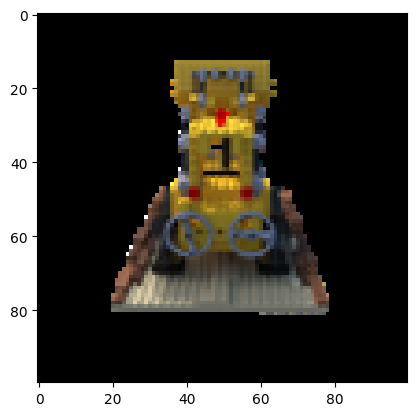

In [ ]:
list_image = []
for i in range(num_chunk_per_h):
  index = i*num_chunk_per_w
  images_tmp = images_chunks[index]
  for j in range(1,num_chunk_per_w):
    images_tmp = np.concatenate((images_tmp, images_chunks[index+j]), axis=1)
  list_image.append(images_tmp)

new_images = list_image[0]
for i in range(1, num_chunk_per_h):
  new_images = np.concatenate((new_images, list_image[i]), axis=0)
plt.imshow(new_images)

Tạo dữ liệu validation

In [ ]:
val_images = images[split_index:]
val_poses = poses[split_index:]

# Make the validation pipeline.
val_img_ds = tf.data.Dataset.from_tensor_slices(val_images)
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses)

images_chunks, pose_chunk, mesh_grid_chunks = split_chunk(val_img_ds, val_pose_ds)

train_img_ds = tf.data.Dataset.from_tensor_slices(images_chunks)
train_pose_ds = tf.data.Dataset.from_tensor_slices(pose_chunk) # num_imgs_train
mesh_grid_chunks = tf.data.Dataset.from_tensor_slices(mesh_grid_chunks)

val_ray_ds = tf.data.Dataset.zip((train_pose_ds, mesh_grid_chunks)).map(map_fn, num_parallel_calls=AUTO)

validation_ds = tf.data.Dataset.zip((train_img_ds, val_ray_ds))
data_val = (
    validation_ds #.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)


result Tensor("concat:0", shape=(40000, 63), dtype=float32)
result Tensor("concat_1:0", shape=(40000, 27), dtype=float32)
result Tensor("concat_2:0", shape=(40000, 63), dtype=float32)


# V. Model

## Xây dựng hàm log

In [ ]:
def merge_images(chunk_images):
  list_image = []
  for i in range(num_chunk_per_h):
    index = i*num_chunk_per_w
    images_tmp = chunk_images[index]
    for j in range(1,num_chunk_per_w):

      images_tmp = np.concatenate((images_tmp, chunk_images[index+j]), axis=1)
    list_image.append(images_tmp)


  big_image = list_image[0]
  for i in range(1, num_chunk_per_h):
    big_image = np.concatenate((big_image, list_image[i]), axis=0)
  return big_image


tạo ra bộ test ảnh lớn

In [ ]:
data_test = iter(data_val)

list_test_R_samples = []
list_test_dirs_samples =[]
list_test_origin_samples =[]
list_test_tCoarse =[]
list_ray_origins =[]
list_ray_directions =[]

test_big_img = []
img_per_row = []
i_w = 0
i_h = 0
while i_h < num_chunk_per_h :
  test_imgs, test_rays = next(data_test)
  (R_samples_tmp, dirs_samples_tmp, origin_samples_tmp, tCoarse_tmp, ray_origins_tmp, ray_directions_tmp) = test_rays
  list_test_R_samples.append(R_samples_tmp)
  list_test_dirs_samples.append(dirs_samples_tmp)
  list_test_origin_samples.append(origin_samples_tmp)
  list_test_tCoarse.append(tCoarse_tmp)
  list_ray_origins.append(ray_origins_tmp)
  list_ray_directions.append(ray_directions_tmp)
  for test_img in test_imgs:
      
    # Noi anh theo hang
    i_w +=1
    if len(img_per_row) > 0:
      img_per_row = np.concatenate((img_per_row, test_img), axis=1)
    else:
      img_per_row = test_img

    # Xuong dong
    if i_w == num_chunk_per_w:
      if len(test_big_img) > 0:
        test_big_img = np.concatenate((test_big_img, img_per_row), axis=0)
      else:
        test_big_img = img_per_row
      i_h +=1
      i_w = 0
      # tao dong moi
      img_per_row = []


In [ ]:
loss_list = []
class LogManager(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)
        list_chunk_rgp = []
        list_chunk_depth = []
        i = 0
        for test_R_samples, test_dirs_samples, test_origin_samples, test_tCoarse, ray_origins, ray_directions in zip(list_test_R_samples, list_test_dirs_samples, list_test_origin_samples, list_test_tCoarse, list_ray_origins, list_ray_directions):
          imagesCoarse, _, weightsCoarse = volume_rendering(model=self.model.coarse_model, R_samples=test_R_samples, dirs_samples=test_dirs_samples,origin_samples=test_origin_samples, t=test_tCoarse,num_sample=NUM_SAMPLES, rand=True, train=False)
            
          # model tinh
          num_sample = NUM_SAMPLES + NUM_FINE_SAMPLES
          tCoarse_tmp = tf.concat([tf.zeros_like(test_tCoarse[..., :1]), test_tCoarse], axis=-1)
          tCoarseMid = (0.5 *	(tCoarse_tmp[..., 1:] + tCoarse_tmp[..., :-1]))
          
          tFine = sample_pdf(tCoarseMid=tCoarseMid, weightsCoarse=weightsCoarse)
          tFine = tf.sort(tf.concat([test_tCoarse, tFine], axis=-1), axis=-1)

          O_origin = ray_origins[..., None, :] #(100, 100, 1,3)
          D_origin = ray_directions[..., None, :] #(100, 100, 1, 3)
          T = tFine[..., None] #(num_samples, 1)
          
          # Toạ độ của từng điểm
          # r(t) = o + td -> Building the "r" here.
          R_samples_Fine = O_origin + (D_origin * T) #(100, 100, 32, 3) (W, H, num_samples, coordinate)
          R_samples_Fine = tf.reshape(R_samples_Fine, [BATCH_SIZE,-1, 3]) # (320000, 3)
          R_samples_Fine = encode_position(R_samples_Fine, en_type = "ray")# (320000, 63)

          # Hướng của từng điểm
          tmp = tf.ones(T.shape)
          dirs_samples_Fine = D_origin*tmp #(100, 100, 32, 3)
          dirs_samples_Fine = tf.reshape(dirs_samples_Fine, [BATCH_SIZE,-1, 3]) # (320000, 3)
          dirs_samples_Fine = encode_position(dirs_samples_Fine, en_type = "dir") # (320000, 27)

          # Toạ độ điểm gốc
          origin_samples_Fine = O_origin*tmp #(100, 100, 32, 3)
          origin_samples_Fine = tf.reshape(origin_samples_Fine, [BATCH_SIZE,-1, 3]) # (320000, 3)
          origin_samples_Fine = encode_position(origin_samples_Fine, en_type = "ray") # (320000, 27)

          test_recons_images, depth_maps,_  = volume_rendering(model=self.model.fine_model, R_samples=R_samples_Fine, dirs_samples=dirs_samples_Fine,origin_samples=origin_samples_Fine, t=tFine,num_sample=num_sample, rand=True, train=False)
          
          for recons_images, depth_map in zip(test_recons_images, depth_maps):
            list_chunk_rgp.append(recons_images)
            list_chunk_depth.append(depth_map)
        # Plot the rgb, depth and the loss plot.
        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
      
        # origin_images
        ax[0].imshow(keras.preprocessing.image.array_to_img(test_big_img))
        ax[0].set_title(f"origin: {epoch:03d}")

        #novel view
        nv_images = merge_images(list_chunk_rgp[:num_chunk_per_image])
        ax[1].imshow(keras.preprocessing.image.array_to_img(nv_images))
        ax[1].set_title(f"Novel_view: {epoch:03d}")

        #depth img
        depth_img = merge_images(list_chunk_depth[:num_chunk_per_image])
        ax[2].imshow(keras.preprocessing.image.array_to_img(depth_img[..., None]))
        ax[2].set_title(f"Depth_map: {epoch:03d}")

        ax[3].plot(loss_list)
        ax[3].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
        ax[3].set_title(f"Loss Plot: {epoch:03d}")

        fig.savefig(f"logs/{epoch:03d}.png")
        plt.show()
        plt.close()

## Xây dựng mô hình

In [ ]:
class BuildModel():
  @staticmethod
  def get_Coarsemodel():
    NUM_POS = CHUNK_SIZE[0] * CHUNK_SIZE[1] * NUM_SAMPLES
    rayInput = keras.Input(shape=(NUM_POS, 2 * 3 * POS_ENCODE_DIMS + 3))
    dirInput = keras.Input(shape=(NUM_POS, 2 * 3 * DIR_ENCODE_DIMS + 3))
    orgInput = keras.Input(shape=(NUM_POS, 2 * 3 * POS_ENCODE_DIMS + 3))

    hidden_layer1 = Dense(HIDDEN_LAYER_COARSE, activation=ACTIVATION_FUNC)(rayInput)
    hidden_layer2 = Dense(HIDDEN_LAYER_COARSE, activation=ACTIVATION_FUNC)(hidden_layer1)
    hidden_layer3 = Dense(HIDDEN_LAYER_COARSE, activation=ACTIVATION_FUNC)(hidden_layer2)
    hidden_layer4 = Dense(HIDDEN_LAYER_COARSE, activation=ACTIVATION_FUNC)(hidden_layer3)
    hidden_layer4c = layers.concatenate([hidden_layer4, rayInput], axis=-1)
    hidden_layer5 = Dense(HIDDEN_LAYER_COARSE, activation=ACTIVATION_FUNC)(hidden_layer4c)
    hidden_layer6 = Dense(HIDDEN_LAYER_COARSE, activation=ACTIVATION_FUNC)(hidden_layer5)
    hidden_layer7 = Dense(HIDDEN_LAYER_COARSE, activation=ACTIVATION_FUNC)(hidden_layer6)
    hidden_layer8 = Dense(HIDDEN_LAYER_COARSE, activation=ACTIVATION_FUNC)(hidden_layer7)

    hidden_layer9 = Dense(HIDDEN_LAYER_COARSE, activation=ACTIVATION_FUNC)(hidden_layer8)
    sigma = Dense(units=1, activation=ACTIVATION_FUNC)(hidden_layer9)

    hidden_layer11 = Dense(HIDDEN_LAYER, activation=ACTIVATION_FUNC)(dirInput)
    hidden_layer12 = layers.concatenate([hidden_layer11, hidden_layer8], axis=-1)
    hidden_layer13 = Dense(HIDDEN_LAYER//2, activation=ACTIVATION_FUNC)(hidden_layer12)
    rgb = Dense(units=3, activation=ACTIVATION_FUNC)(hidden_layer13)

    hidden_layer14 = Dense(HIDDEN_LAYER, activation=ACTIVATION_FUNC)(orgInput)
    hidden_layer15 = layers.concatenate([hidden_layer14, hidden_layer8 ], axis=-1)
    hidden_layer16 = Dense(HIDDEN_LAYER//2, activation=ACTIVATION_FUNC)(hidden_layer15)
    shutter_speed = Dense(units=1, activation=ACTIVATION_FUNC)(hidden_layer16)

    model = keras.Model(inputs=[rayInput, dirInput, orgInput], outputs= [rgb, sigma, shutter_speed])

    return model

  @staticmethod
  def get_Finemodel():
    num_pos_f = CHUNK_SIZE[0] * CHUNK_SIZE[1] * (NUM_SAMPLES + NUM_FINE_SAMPLES)
    rayInput = keras.Input(shape=(num_pos_f, 2 * 3 * POS_ENCODE_DIMS + 3))
    dirInput = keras.Input(shape=(num_pos_f, 2 * 3 * DIR_ENCODE_DIMS + 3))
    orgInput = keras.Input(shape=(num_pos_f, 2 * 3 * POS_ENCODE_DIMS + 3))

    hidden_layer1 = Dense(HIDDEN_LAYER, activation=ACTIVATION_FUNC)(rayInput)
    hidden_layer2 = Dense(HIDDEN_LAYER, activation=ACTIVATION_FUNC)(hidden_layer1)
    hidden_layer3 = Dense(HIDDEN_LAYER, activation=ACTIVATION_FUNC)(hidden_layer2)
    hidden_layer4 = Dense(HIDDEN_LAYER, activation=ACTIVATION_FUNC)(hidden_layer3)
    hidden_layer4c = layers.concatenate([hidden_layer4, rayInput], axis=-1)
    hidden_layer5 = Dense(HIDDEN_LAYER, activation=ACTIVATION_FUNC)(hidden_layer4c)
    hidden_layer6 = Dense(HIDDEN_LAYER, activation=ACTIVATION_FUNC)(hidden_layer5)
    hidden_layer7 = Dense(HIDDEN_LAYER, activation=ACTIVATION_FUNC)(hidden_layer6)
    hidden_layer8 = Dense(HIDDEN_LAYER, activation=ACTIVATION_FUNC)(hidden_layer7)

    hidden_layer9 = Dense(HIDDEN_LAYER, activation=ACTIVATION_FUNC)(hidden_layer8)
    sigma = Dense(units=1, activation=ACTIVATION_FUNC)(hidden_layer9)
    
    hidden_layer11 = Dense(HIDDEN_LAYER, activation=ACTIVATION_FUNC)(dirInput)
    hidden_layer12 = layers.concatenate([hidden_layer11, hidden_layer8], axis=-1)
    hidden_layer13 = Dense(HIDDEN_LAYER//2, activation=ACTIVATION_FUNC)(hidden_layer12)
    rgb = Dense(units=3, activation=ACTIVATION_FUNC)(hidden_layer13)

    hidden_layer14 = Dense(HIDDEN_LAYER, activation=ACTIVATION_FUNC)(orgInput)
    hidden_layer15 = layers.concatenate([hidden_layer14, hidden_layer8 ], axis=-1)
    hidden_layer16 = Dense(HIDDEN_LAYER//2, activation=ACTIVATION_FUNC)(hidden_layer15)
    shutter_speed = Dense(units=1, activation=ACTIVATION_FUNC)(hidden_layer16)

    model = keras.Model(inputs=[rayInput, dirInput, orgInput], outputs= [rgb, sigma, shutter_speed])

    return model

### Mô hình thô

In [ ]:
coarse_model = BuildModel.get_Coarsemodel()
coarse_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 40000, 63)]  0           []                               
                                                                                                  
 dense_64 (Dense)               (None, 40000, 32)    2048        ['input_13[0][0]']               
                                                                                                  
 dense_65 (Dense)               (None, 40000, 32)    1056        ['dense_64[0][0]']               
                                                                                                  
 dense_66 (Dense)               (None, 40000, 32)    1056        ['dense_65[0][0]']               
                                                                                            

### Mô hình tinh

In [ ]:
find_model = BuildModel.get_Finemodel()
find_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 80000, 63)]  0           []                               
                                                                                                  
 dense_80 (Dense)               (None, 80000, 32)    2048        ['input_16[0][0]']               
                                                                                                  
 dense_81 (Dense)               (None, 80000, 32)    1056        ['dense_80[0][0]']               
                                                                                                  
 dense_82 (Dense)               (None, 80000, 32)    1056        ['dense_81[0][0]']               
                                                                                            

In [ ]:
class NeRF(keras.Model):
    def __init__(self, coarse_model,fine_model):
        super().__init__()
        self.coarse_model = coarse_model
        self.fine_model = fine_model

    def compile(self, optimizerCoarse, optimizerFine, loss_fn):
        '''Cấu hình cho model'''
        super().compile()
        self.optimizerCoarse = optimizerCoarse
        self.optimizerFine = optimizerFine
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_metric = keras.metrics.Mean(name="psnr")

    def train_step(self, training_ds):

        
        (images, rays) = training_ds
        (R_samples, dirs_samples, origin_samples, tCoarse, ray_origins, ray_directions) = rays

        # model thô
        num_sample = NUM_SAMPLES
        with tf.GradientTape() as coarseTape:
          # Lấy kết quả dự đoán từ model
          imagesCoarse, _, weightsCoarse = volume_rendering(model=self.coarse_model, R_samples=R_samples, dirs_samples=dirs_samples,origin_samples=origin_samples, t=tCoarse, num_sample = num_sample, rand=True)
          lossCoarse = self.loss_fn(images, imagesCoarse)
          
          # Lan truyền ngược
          tvCoarse = self.coarse_model.trainable_variables
          gradsCoarse = coarseTape.gradient(lossCoarse, tvCoarse)
          self.optimizerCoarse.apply_gradients(zip(gradsCoarse, tvCoarse))
          
        del R_samples, dirs_samples, origin_samples,lossCoarse, tvCoarse, gradsCoarse

        # model tinh
        num_sample = NUM_SAMPLES + NUM_FINE_SAMPLES
        tCoarse_tmp = tf.concat([tf.zeros_like(tCoarse[..., :1]), tCoarse], axis=-1)
        tCoarseMid = (0.5 *	(tCoarse_tmp[..., 1:] + tCoarse_tmp[..., :-1]))
        tFine = sample_pdf(tCoarseMid=tCoarseMid, weightsCoarse=weightsCoarse)
        tFine = tf.sort(tf.concat([tCoarse, tFine], axis=-1), axis=-1)
        
        O_origin = ray_origins[..., None, :] #(100, 100, 1,3)
        D_origin = ray_directions[..., None, :] #(100, 100, 1, 3)
        T = tFine[..., None] #(num_samples, 1)
        
        # Toạ độ của từng điểm
        # r(t) = o + td -> Building the "r" here.
        R_samples_Fine = O_origin + (D_origin * T) #(100, 100, 32, 3) (W, H, num_samples, coordinate)
        R_samples_Fine = tf.reshape(R_samples_Fine, [BATCH_SIZE,-1, 3]) # (320000, 3)
        R_samples_Fine = encode_position(R_samples_Fine, en_type = "ray")# (320000, 63)

        # Hướng của từng điểm
        tmp = tf.ones(T.shape)
        dirs_samples_Fine = D_origin*tmp #(100, 100, 32, 3)
        dirs_samples_Fine = tf.reshape(dirs_samples_Fine, [BATCH_SIZE,-1, 3]) # (320000, 3)
        dirs_samples_Fine = encode_position(dirs_samples_Fine, en_type = "dir") # (320000, 27)

        # Toạ độ điểm gốc
        origin_samples_Fine = O_origin*tmp #(100, 100, 32, 3)
        origin_samples_Fine = tf.reshape(origin_samples_Fine, [BATCH_SIZE,-1, 3]) # (320000, 3)
        origin_samples_Fine = encode_position(origin_samples_Fine, en_type = "ray") # (320000, 27)

        with tf.GradientTape() as fineTape:
          imagesFine, _, weightsFine = volume_rendering(model=self.fine_model, R_samples=R_samples_Fine, dirs_samples=dirs_samples_Fine,origin_samples=origin_samples_Fine, t=tFine, num_sample = num_sample, rand=True)
          lossFine = self.loss_fn(images, imagesFine)

          tvFine = self.fine_model.trainable_variables
          gradsFine = fineTape.gradient(lossFine, tvFine)
          self.optimizerCoarse.apply_gradients(zip(gradsFine, tvFine))

        psnr = tf.image.psnr(images, imagesFine, max_val=1.0)

        # Tính toán số liệu riêng để hiển thị về sau
        self.loss_tracker.update_state(lossFine)
        self.psnr_metric.update_state(psnr)

        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    def test_step(self, inputs):
        '''Đánh gía mô hình trên tập dữ liệu kiểm tra'''
        
        # Get the images and the rays.
        (images, rays) = inputs
        (R_samples, dirs_samples, origin_samples, tCoarse, ray_origins, ray_directions) = rays
        num_sample = NUM_SAMPLES
        imagesCoarse, _, weightsCoarse = volume_rendering(model=self.coarse_model, R_samples=R_samples, dirs_samples=dirs_samples,origin_samples=origin_samples, t=tCoarse,num_sample=num_sample, rand=True, train=False)
          

        # model tinh
        num_sample = NUM_SAMPLES + NUM_FINE_SAMPLES
        tCoarse_tmp = tf.concat([tf.zeros_like(tCoarse[..., :1]), tCoarse], axis=-1)
        tCoarseMid = (0.5 *	(tCoarse_tmp[..., 1:] + tCoarse_tmp[..., :-1]))
        
        tFine = sample_pdf(tCoarseMid=tCoarseMid, weightsCoarse=weightsCoarse)
        tFine = tf.sort(tf.concat([tCoarse, tFine], axis=-1), axis=-1)

        O_origin = ray_origins[..., None, :] #(100, 100, 1,3)
        D_origin = ray_directions[..., None, :] #(100, 100, 1, 3)
        T = tFine[..., None] #(num_samples, 1)
        
        # Toạ độ của từng điểm
        # r(t) = o + td -> Building the "r" here.
        R_samples_Fine = O_origin + (D_origin * T) #(100, 100, 32, 3) (W, H, num_samples, coordinate)
        R_samples_Fine = tf.reshape(R_samples_Fine, [BATCH_SIZE,-1, 3]) # (320000, 3)
        R_samples_Fine = encode_position(R_samples_Fine, en_type = "ray")# (320000, 63)

        # Hướng của từng điểm
        tmp = tf.ones(T.shape)
        dirs_samples_Fine = D_origin*tmp #(100, 100, 32, 3)
        dirs_samples_Fine = tf.reshape(dirs_samples_Fine, [BATCH_SIZE,-1, 3]) # (320000, 3)
        dirs_samples_Fine = encode_position(dirs_samples_Fine, en_type = "dir") # (320000, 27)

        # Toạ độ điểm gốc
        origin_samples_Fine = O_origin*tmp #(100, 100, 32, 3)
        origin_samples_Fine = tf.reshape(origin_samples_Fine, [BATCH_SIZE,-1, 3]) # (320000, 3)
        origin_samples_Fine = encode_position(origin_samples_Fine, en_type = "ray") # (320000, 27)

        imagesFine, _, weightsFine = volume_rendering(model=self.fine_model, R_samples=R_samples_Fine, dirs_samples=dirs_samples_Fine,origin_samples=origin_samples_Fine, t=tFine,num_sample=num_sample, rand=True, train=False)
        
        lossFine = self.loss_fn(images, imagesFine)
        self.loss_tracker.update_state(lossFine)

        psnr = tf.image.psnr(images, imagesFine, max_val=1.0)
        self.psnr_metric.update_state(psnr)
        
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_metric]

# VI. Trainning

## 1.Train

In [ ]:
nerf_model = NeRF(coarse_model,find_model)
nerf_model.compile(optimizerCoarse=tf.keras.optimizers.legacy.Adam(),optimizerFine=tf.keras.optimizers.legacy.Adam(), loss_fn=keras.losses.MeanSquaredError())

In [ ]:
num_step = split_index*num_chunk_per_image//BATCH_SIZE # Số lượng chunk/batchsize 

In [ ]:
nerf_model.fit(
    data_train,
    validation_data = data_val,
    batch_size      =BATCH_SIZE,
    epochs          =EPOCHS,
    callbacks       =[LogManager()],
    steps_per_epoch =num_step,
)

Epoch 1/200
 1/64 [..............................] - ETA: 4:21 - loss: 0.0316 - psnr: 15.0181

KeyboardInterrupt: 

## 2.Phân tích mô hình thu được

In [ ]:
# Trọng số
nerf_model.trainable_variables

[<tf.Variable 'dense_308/kernel:0' shape=(63, 32) dtype=float32, numpy=
 array([[-0.16209221,  0.24829085, -0.09399366, ..., -0.08967727,
         -0.19256945, -0.23580782],
        [ 0.15575717,  0.20413443,  0.21353203, ..., -0.1403867 ,
         -0.00903507, -0.16485782],
        [-0.17709355, -0.12783441,  0.03079392, ...,  0.07562488,
         -0.09611759, -0.11493251],
        ...,
        [ 0.07582904, -0.18276392, -0.16807286, ..., -0.11336978,
          0.12455659, -0.03762427],
        [-0.02372299,  0.04606304,  0.07137445, ..., -0.0856875 ,
         -0.19636916,  0.21365272],
        [ 0.19093661, -0.03323378,  0.13764068, ...,  0.19740568,
         -0.06653908, -0.10563497]], dtype=float32)>,
 <tf.Variable 'dense_308/bias:0' shape=(32,) dtype=float32, numpy=
 array([-2.22659390e-02,  9.36261471e-03,  7.15588033e-03, -2.21980195e-02,
         3.74313910e-03,  1.97310094e-03, -2.25501321e-02,  1.90941710e-02,
        -1.63496342e-02, -6.58983830e-03,  2.26698406e-02, -1.8691

In [ ]:
test_R_samples, test_dirs_samples, test_origin_samples, test_tCoarse, ray_origins, ray_directions

NameError: name 'test_R_samples' is not defined

### 1.Validation

In [ ]:
imagesCoarse, _, weightsCoarse = volume_rendering(model=nerf_model.coarse_model, R_samples=test_R_samples, dirs_samples=test_dirs_samples,origin_samples=test_origin_samples, t=test_tCoarse,num_sample=NUM_SAMPLES, rand=True, train=False)
          
# model tinh
num_sample = NUM_SAMPLES + NUM_FINE_SAMPLES
tCoarse_tmp = tf.concat([tf.zeros_like(test_tCoarse[..., :1]), test_tCoarse], axis=-1)
tCoarseMid = (0.5 *	(tCoarse_tmp[..., 1:] + tCoarse_tmp[..., :-1]))

tFine = sample_pdf(tCoarseMid=tCoarseMid, weightsCoarse=weightsCoarse)
tFine = tf.sort(tf.concat([test_tCoarse, tFine], axis=-1), axis=-1)

O_origin = ray_origins[..., None, :] #(100, 100, 1,3)
D_origin = ray_directions[..., None, :] #(100, 100, 1, 3)
T = tFine[..., None] #(num_samples, 1)

# Toạ độ của từng điểm
# r(t) = o + td -> Building the "r" here.
R_samples_Fine = O_origin + (D_origin * T) #(100, 100, 32, 3) (W, H, num_samples, coordinate)
R_samples_Fine = tf.reshape(R_samples_Fine, [BATCH_SIZE,-1, 3]) # (320000, 3)
R_samples_Fine = encode_position(R_samples_Fine, en_type = "ray")# (320000, 63)

# Hướng của từng điểm
tmp = tf.ones(T.shape)
dirs_samples_Fine = D_origin*tmp #(100, 100, 32, 3)
dirs_samples_Fine = tf.reshape(dirs_samples_Fine, [BATCH_SIZE,-1, 3]) # (320000, 3)
dirs_samples_Fine = encode_position(dirs_samples_Fine, en_type = "dir") # (320000, 27)

# Toạ độ điểm gốc
origin_samples_Fine = O_origin*tmp #(100, 100, 32, 3)
origin_samples_Fine = tf.reshape(origin_samples_Fine, [BATCH_SIZE,-1, 3]) # (320000, 3)
origin_samples_Fine = encode_position(origin_samples_Fine, en_type = "ray") # (320000, 27)

test_recons_images, depth_maps,_  = volume_rendering(model=nerf_model.fine_model, R_samples=R_samples_Fine, dirs_samples=dirs_samples_Fine,origin_samples=origin_samples_Fine, t=tFine,num_sample=num_sample, rand=True, train=False)



# Create subplots.
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 20))

index = 0
for ax in axes:
    
    # origin image
    org_chunk1 = test_imgs[index]
    org_chunk2 = test_imgs[index + 1]
    org_chunk3 = test_imgs[index + 2]
    org_chunk4 = test_imgs[index + 3]
    image_top = np.concatenate((org_chunk1, org_chunk2), axis=1)
    image_bot = np.concatenate((org_chunk3, org_chunk4), axis=1)
    origin_image = np.concatenate((image_top, image_bot), axis=0)
    ax[0].imshow(keras.preprocessing.image.array_to_img(origin_image))
    ax[0].set_title("Original")

    # reconstruct image
    chunk1 = test_recons_images[index]
    chunk2 = test_recons_images[index + 1]
    chunk3 = test_recons_images[index + 2]
    chunk4 = test_recons_images[index + 3]
    image_top = np.concatenate((chunk1, chunk2), axis=1)
    image_bot = np.concatenate((chunk3, chunk4), axis=1)
    recons_img = np.concatenate((image_top, image_bot), axis=0)
    ax[1].imshow(keras.preprocessing.image.array_to_img(recons_img))
    ax[1].set_title("Reconstructed")

    # depth map
    chunk1 = depth_maps[index]
    chunk2 = depth_maps[index+1]
    chunk3 = depth_maps[index+2]
    chunk4 = depth_maps[index+3]
    image_top = np.concatenate((chunk1, chunk2), axis=1)
    image_bot = np.concatenate((chunk3, chunk4), axis=1)
    depth_img = np.concatenate((image_top, image_bot), axis=0)
    ax[2].imshow(keras.preprocessing.image.array_to_img(depth_img[..., None]), cmap="inferno")
    ax[2].set_title("Depth Map")

    index += 4

# VII. Export

## 1. Novel view

In [ ]:
def get_translation_t(t):
    """Get the translation matrix for movement in t."""
    matrix = [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_phi(phi):
    """Get the rotation matrix for movement in phi."""
    matrix = [
        [1, 0, 0, 0],
        [0, tf.cos(phi), -tf.sin(phi), 0],
        [0, tf.sin(phi), tf.cos(phi), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_theta(theta):
    """Get the rotation matrix for movement in theta."""
    matrix = [
        [tf.cos(theta), 0, -tf.sin(theta), 0],
        [0, 1, 0, 0],
        [tf.sin(theta), 0, tf.cos(theta), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def pose_spherical(theta, phi, t):
    """
    Get the camera to world matrix for the corresponding theta, phi
    and t.
    """
    c2w = get_translation_t(t)
    c2w = get_rotation_phi(phi / 180.0 * np.pi) @ c2w
    c2w = get_rotation_theta(theta / 180.0 * np.pi) @ c2w
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w


rgb_frames = []
batch_flat = []
batch_t = []

# Iterate over different theta value and generate scenes.
for index, theta in tqdm(enumerate(np.linspace(0.0, 360.0, 120, endpoint=False))):
    # Get the camera to world matrix.
    c2w = pose_spherical(theta, -30.0, 4.0)

    #
    ray_oris, ray_dirs = get_rays(H, W, focal, c2w)
    rays_flat, t_vals = render_flat_rays(
        ray_oris, ray_dirs, near=2.0, far=6.0, num_samples=NUM_SAMPLES, rand=False
    )

    if index % BATCH_SIZE == 0 and index > 0:
        batched_flat = tf.stack(batch_flat, axis=0)
        batch_flat = [rays_flat]

        batched_t = tf.stack(batch_t, axis=0)
        batch_t = [t_vals]

        rgb, _ = volume_rendering(
            nerf_model, batched_flat, batched_t, rand=False, train=False
        )

        temp_rgb = [np.clip(255 * img, 0.0, 255.0).astype(np.uint8) for img in rgb]

        rgb_frames = rgb_frames + temp_rgb
    else:
        batch_flat.append(rays_flat)
        batch_t.append(t_vals)

name_video = "rgb_video.mp4"
imageio.mimwrite(name_video, rgb_frames, fps=30, quality=7, macro_block_size=None)